In [55]:
import pandas as pd
from matplotlib import pyplot as plt
from pipeline.acquisition import load_sisfall_data
from pipeline.preprocessing import change_activity_duration
from pipeline.preprocessing import change_activity_sampling
from pipeline.feature_extraction import extract_features
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression



In [56]:
dataset_folder = "datasets/SisFall_dataset/"
models_output_folder = 'models/'
uma_dataset_folder = "datasets/output_uma"

INCLUDE_GYROSCOPE = False

if INCLUDE_GYROSCOPE:
    sensors =  [0, 1, 2, 3, 4, 5]
else:
    sensors = [0, 1, 2]

ignored_subjects = []
duration = 12000
frequency = 200

should_save_models = True

In [57]:

def plot_sensor_data(data):
    # Create a comprehensive plot showing all sensor readings
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Plot accelerometer data
    axes[0].plot(data.index, data['acc_x'], label='X-axis', color='red', linewidth=1)
    axes[0].plot(data.index, data['acc_y'], label='Y-axis', color='green', linewidth=1)
    axes[0].plot(data.index, data['acc_z'], label='Z-axis', color='blue', linewidth=1)
    axes[0].set_title('Accelerometer Data', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Acceleration (g)', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot gyroscope data
    if INCLUDE_GYROSCOPE:
        axes[1].plot(data.index, data['gyro_x'], label='X-axis', color='red', linewidth=1)
        axes[1].plot(data.index, data['gyro_y'], label='Y-axis', color='green', linewidth=1)
        axes[1].plot(data.index, data['gyro_z'], label='Z-axis', color='blue', linewidth=1)
        axes[1].set_title('Gyroscope Data ', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Time', fontsize=12)
        axes[1].set_ylabel('Angular Velocity (deg/s)', fontsize=12)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

    # Print some basic statistics
    print("Data Summary:")
    print(f"Duration: {len(data)} samples")
    print(f"Sampling period: ~{(data.index[1] - data.index[0]).total_seconds():.3f} seconds")
    print(f"Total duration: ~{(data.index[-1] - data.index[0]).total_seconds():.1f} seconds")

    print("\nAccelerometer Statistics:")
    print(data[['acc_x', 'acc_y', 'acc_z']].describe())

    if INCLUDE_GYROSCOPE:
        print("\nGyroscope Statistics:")
        print(data[['gyro_x', 'gyro_y', 'gyro_z']].describe())





In [58]:
sensors

[0, 1, 2]

In [59]:
# Loads SisFall dataset
raw_dataset = load_sisfall_data(dataset_folder, ignored_subjects, sensors)
raw_dataset

,subject,activity,trial,data
0,SA01,D01,R01,acc_x acc_y ...
1,SA01,D01,R01,acc_x acc_y ...
2,SA01,D01,R01,acc_x acc_y ...
3,SA01,D01,R01,acc_x acc_y ...
4,SA01,D01,R01,acc_x acc_y ...
...,...,...,...,...
5100,SE15,D17,R01,acc_x acc_y ...
5101,SE15,D17,R02,acc_x acc_y ...
5102,SE15,D17,R03,acc_x acc_y ...
5103,SE15,D17,R04,acc_x acc_y ...


In [60]:
raw_dataset['data'][0]

,acc_x,acc_y,acc_z
2000-01-01 00:00:05.000,-0.003906,-0.886719,-0.421875
2000-01-01 00:00:05.005,-0.019531,-0.859375,-0.398438
2000-01-01 00:00:05.010,-0.046875,-0.820312,-0.390625
2000-01-01 00:00:05.015,-0.062500,-0.808594,-0.386719
2000-01-01 00:00:05.020,-0.082031,-0.824219,-0.351562
...,...,...,...
2000-01-01 00:00:14.975,0.027344,-0.953125,0.121094
2000-01-01 00:00:14.980,0.042969,-0.968750,0.113281
2000-01-01 00:00:14.985,0.042969,-0.968750,0.105469
2000-01-01 00:00:14.990,0.035156,-0.968750,0.121094


In [62]:
for activity in ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15']:
	activity_data = raw_dataset[raw_dataset['activity'] == activity]
	print(f"Shape of {activity}: {activity_data.shape}")

Shape of F01: (119, 4)
Shape of F02: (120, 4)
Shape of F03: (120, 4)
Shape of F04: (120, 4)
Shape of F05: (120, 4)
Shape of F06: (120, 4)
Shape of F07: (120, 4)
Shape of F08: (120, 4)
Shape of F09: (120, 4)
Shape of F10: (119, 4)
Shape of F11: (120, 4)
Shape of F12: (120, 4)
Shape of F13: (120, 4)
Shape of F14: (120, 4)
Shape of F15: (120, 4)


In [65]:
ACTIVITY_CLASSES = {
    'walking': ['D01', 'D02'],  
    'jogging': ['D03', 'D04'],
    'fall': ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', "F11","F12","F13", "F14","F15"],
    'lying': ['D14'],
    'sitting': ['D11',"D12", "D13"],
    "jumping": ['D19']
}

# Create code to class mapping
CODE_TO_CLASS = {}
for class_name, codes in ACTIVITY_CLASSES.items():
    for code in codes:
        CODE_TO_CLASS[code] = class_name

print("Activity classes defined:")
for class_name, codes in ACTIVITY_CLASSES.items():
    print(f"  {class_name}: {codes}")

Activity classes defined:
  walking: ['D01', 'D02']
  jogging: ['D03', 'D04']
  fall: ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15']
  lying: ['D14']
  sitting: ['D11', 'D12', 'D13']
  jumping: ['D19']


In [67]:
filtered_indices = []
for i in raw_dataset.index:
    activity_code = raw_dataset['activity'][i]
    if activity_code in CODE_TO_CLASS:
        filtered_indices.append(i)

print(f"Total samples: {len(raw_dataset)}")
print(f"Filtered samples (walking + sitting): {len(filtered_indices)}")

print("Processing data...")
feature_list = []
labels = []
subjects = []
activity_codes = []

for i in filtered_indices:
    # Get data and preprocess
    data = raw_dataset['data'][i]
    data = change_activity_duration(data, duration)
    data = change_activity_sampling(data, frequency)
    
    # Extract features
    features = extract_features(data, True)
    
    # Get class label
    activity_code = raw_dataset['activity'][i]
    class_label = CODE_TO_CLASS[activity_code]
    
    # Store results
    feature_list.append(features)
    labels.append(class_label)
    subjects.append(raw_dataset['subject'][i])
    activity_codes.append(activity_code)

# Combine into final dataset
prepared_dataset = pd.concat(feature_list, ignore_index=True)
prepared_dataset['class'] = labels
prepared_dataset['subject'] = subjects
prepared_dataset['activity_code'] = activity_codes

print(f"Final dataset shape: {prepared_dataset.shape}")
print("\nClass distribution:")
print(prepared_dataset['class'].value_counts())

Total samples: 5105
Filtered samples (walking + sitting): 3358
Processing data...
Final dataset shape: (3358, 39)

Class distribution:
class
fall       1798
sitting     500
walking     380
jogging     370
lying       190
jumping     120
Name: count, dtype: int64


In [68]:
from sklearn.model_selection import train_test_split


X_train,X_test = train_test_split(prepared_dataset, 
    test_size=0.2, 
    stratify=prepared_dataset['class'], 
    random_state=42
)
X_train

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class,subject,activity_code
2305,-0.607376,-0.459214,0.216847,0.989673,0.145374,0.176129,0.031540,0.000397,0.381280,0.419678,...,-0.969727,0.042969,0.981276,-0.210938,-0.031250,0.339844,0.999672,sitting,SA20,D12
2146,-0.589725,-0.054355,-0.308376,1.024381,0.255964,0.327034,0.080711,0.060179,0.505929,0.571869,...,-0.757812,-0.285156,1.002653,-0.007812,0.281250,-0.246094,1.026579,fall,SA18,F13
487,0.030977,-0.939629,-0.016348,0.979068,0.035956,0.090582,0.042553,0.094646,0.189622,0.300968,...,-1.235352,-0.121094,0.670075,0.195312,-0.644531,0.103516,1.252148,walking,SA05,D02
2084,-0.045371,-0.994189,0.072865,1.023855,0.010361,0.206558,0.025991,0.190410,0.101788,0.454486,...,-0.996094,0.046875,0.984646,-0.031250,-0.976562,0.140625,1.005888,jumping,SA18,D19
1616,-0.798052,-0.249613,-0.164294,1.067810,0.237059,0.219931,0.038658,0.081614,0.486887,0.468968,...,-0.093750,-0.207031,1.026311,-0.906250,-0.078125,-0.167969,1.041358,fall,SA14,F03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061,0.072891,-1.035059,-0.468691,1.269523,0.106816,0.576938,0.223396,0.591792,0.326827,0.759565,...,-1.519531,-0.645508,0.482270,0.252930,-0.317383,-0.171875,1.711393,jogging,SE07,D03
2176,0.017578,-0.947617,-0.442207,1.495625,0.419636,1.371214,0.992949,1.640740,0.647793,1.170989,...,-1.342773,-0.699219,0.458169,0.282227,-0.071289,0.039062,2.394494,jogging,SA19,D04
3311,-0.076738,-0.974238,-0.537539,1.747588,0.491239,1.938264,1.076878,1.696296,0.700884,1.392216,...,-1.768555,-0.649414,0.709290,0.292969,-0.073242,-0.061523,2.749574,jogging,SE14,D04
387,0.607080,-0.611901,0.061300,1.043688,0.182708,0.150820,0.011148,0.002119,0.427444,0.388356,...,-0.972656,0.015625,1.000357,1.054688,-0.128906,0.128906,1.077275,sitting,SA04,D12


In [69]:
y_train = X_train['class']
y_test = X_test['class']

X_train = X_train.drop(columns=['class', 'subject', 'activity_code'])
X_test = X_test.drop(columns=['class', 'subject', 'activity_code'])



In [70]:
X_test

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_acc_z,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc
36,-0.420387,-0.092220,0.505002,0.941332,0.268322,0.008606,0.175040,0.006119,0.517998,0.092768,...,1.367188,0.618943,-1.011719,-0.167969,-0.011719,0.883687,0.050781,0.015625,0.867188,1.016293
2953,-0.437013,-0.649437,-0.082428,0.978611,0.163869,0.113937,0.060757,0.000428,0.404808,0.337546,...,0.871094,0.200618,-0.921875,-0.933594,-0.273438,0.966369,-0.058594,-0.210938,0.226562,0.990248
662,-0.237736,-0.469279,-0.414933,1.027363,0.161833,0.479948,0.379101,0.414317,0.402285,0.692782,...,12.875000,13.996752,-0.535156,-0.953125,-0.808594,0.930139,0.039062,0.031250,-0.015625,1.001784
542,-0.143947,-0.394880,-0.485706,1.018830,0.071082,0.452238,0.348230,0.246098,0.266612,0.672487,...,6.843750,8.547944,-0.238281,-0.917969,-0.937500,0.897201,-0.007812,0.148438,-0.007812,1.040479
2365,-0.396610,-0.368097,0.387101,0.993053,0.151995,0.250976,0.265065,0.124524,0.389866,0.500975,...,2.976562,6.922002,-0.546875,-0.910156,0.046875,0.947688,-0.074219,-0.042969,0.777344,0.992935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,0.454580,-0.235394,0.452827,0.974933,0.187369,0.083096,0.243266,0.030342,0.432862,0.288264,...,2.058594,2.942898,0.132812,-0.433594,-0.188477,0.933700,0.957031,0.129883,0.832031,1.016806
2251,-0.124577,-0.247604,-0.715617,1.036568,0.013605,0.359739,0.139914,0.027720,0.116640,0.599783,...,2.515625,2.937375,-0.214844,-0.964844,-0.996094,1.009469,-0.015625,0.218750,-0.285156,1.040677
409,0.030106,-0.659893,-0.573125,1.126755,0.095444,0.324795,0.222613,0.138114,0.308940,0.569908,...,6.460938,6.047338,0.000000,-1.035156,-1.125000,0.980585,0.148438,0.035156,-0.238281,1.164718
2473,-0.361574,-0.585033,-0.178924,1.031043,0.313416,0.253191,0.029147,0.037717,0.559835,0.503181,...,1.636719,2.173745,-0.988281,-0.964844,-0.257812,0.930071,0.082031,-0.019531,-0.070312,1.035261


In [71]:
def save_model(model, filename):
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")




svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

nb = GaussianNB()
nb.fit(X_train, y_train)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)


if should_save_models:
    suffix = '_gyro' if INCLUDE_GYROSCOPE else ''
    save_model(svm, models_output_folder + f'svm_model{suffix}.pkl')
    save_model(rf, models_output_folder + f'rf_model{suffix}.pkl')
    save_model(knn, models_output_folder + f'knn_model{suffix}.pkl')
    save_model(dt, models_output_folder + f'dt_model{suffix}.pkl')
    save_model(nb, models_output_folder + f'nb_model{suffix}.pkl')
    save_model(lr, models_output_folder + f'lr_model{suffix}.pkl')


Model saved to models/svm_model.pkl
Model saved to models/rf_model.pkl
Model saved to models/knn_model.pkl
Model saved to models/dt_model.pkl
Model saved to models/nb_model.pkl
Model saved to models/lr_model.pkl


Model: SVC
Classification Report:
              precision    recall  f1-score   support

        fall       1.00      0.99      1.00       360
     jogging       0.99      0.96      0.97        74
     jumping       1.00      0.96      0.98        24
       lying       0.97      1.00      0.99        38
     sitting       0.97      0.96      0.96       100
     walking       0.94      0.99      0.96        76

    accuracy                           0.98       672
   macro avg       0.98      0.98      0.98       672
weighted avg       0.98      0.98      0.98       672

Confusion Matrix:
Accuracy: 0.9836



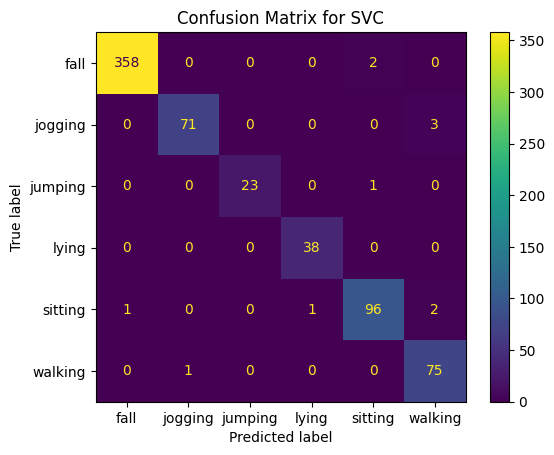

Model: RandomForestClassifier
Classification Report:
              precision    recall  f1-score   support

        fall       0.99      0.99      0.99       360
     jogging       1.00      0.95      0.97        74
     jumping       0.92      1.00      0.96        24
       lying       1.00      0.95      0.97        38
     sitting       0.99      1.00      1.00       100
     walking       0.96      1.00      0.98        76

    accuracy                           0.99       672
   macro avg       0.98      0.98      0.98       672
weighted avg       0.99      0.99      0.99       672

Confusion Matrix:
Accuracy: 0.9881



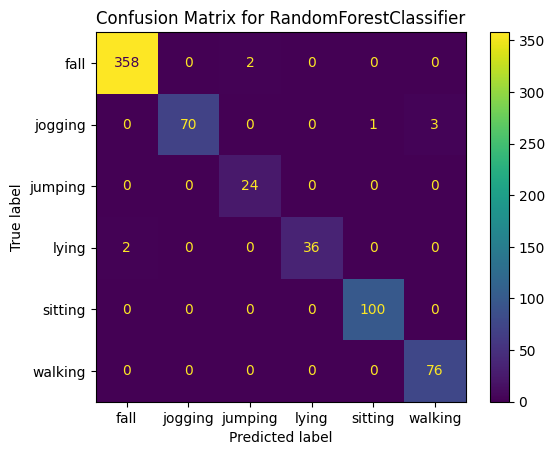

Model: KNeighborsClassifier
Classification Report:
              precision    recall  f1-score   support

        fall       0.99      0.99      0.99       360
     jogging       1.00      0.95      0.97        74
     jumping       0.75      0.88      0.81        24
       lying       1.00      0.89      0.94        38
     sitting       0.94      0.92      0.93       100
     walking       0.94      1.00      0.97        76

    accuracy                           0.97       672
   macro avg       0.94      0.94      0.94       672
weighted avg       0.97      0.97      0.97       672

Confusion Matrix:
Accuracy: 0.9673



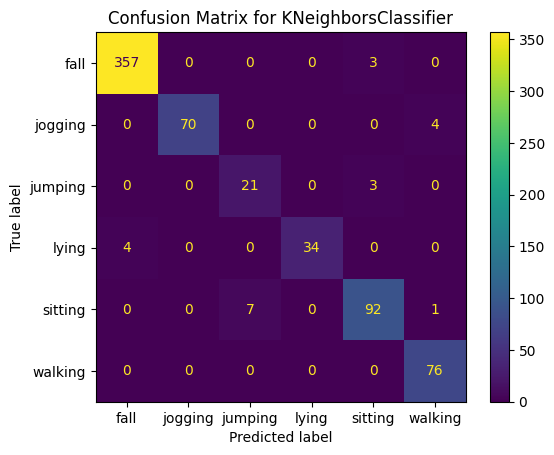

Model: DecisionTreeClassifier
Classification Report:
              precision    recall  f1-score   support

        fall       0.98      0.99      0.99       360
     jogging       0.99      0.93      0.96        74
     jumping       0.96      1.00      0.98        24
       lying       0.97      0.89      0.93        38
     sitting       0.97      0.98      0.98       100
     walking       0.96      0.97      0.97        76

    accuracy                           0.98       672
   macro avg       0.97      0.96      0.97       672
weighted avg       0.98      0.98      0.98       672

Confusion Matrix:
Accuracy: 0.9762



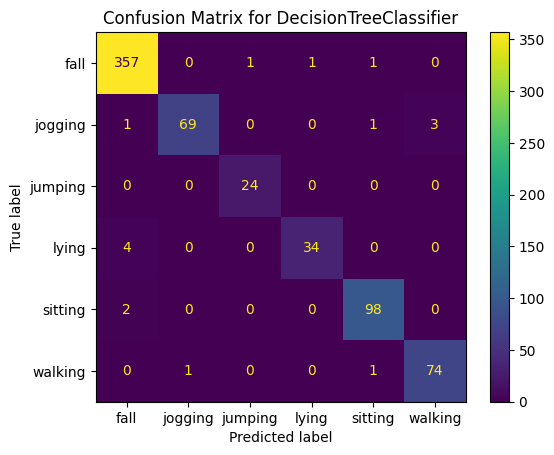

Model: GaussianNB
Classification Report:
              precision    recall  f1-score   support

        fall       0.99      0.98      0.98       360
     jogging       0.96      0.93      0.95        74
     jumping       0.89      1.00      0.94        24
       lying       0.97      0.92      0.95        38
     sitting       0.91      0.91      0.91       100
     walking       0.91      0.96      0.94        76

    accuracy                           0.96       672
   macro avg       0.94      0.95      0.94       672
weighted avg       0.96      0.96      0.96       672

Confusion Matrix:
Accuracy: 0.9583



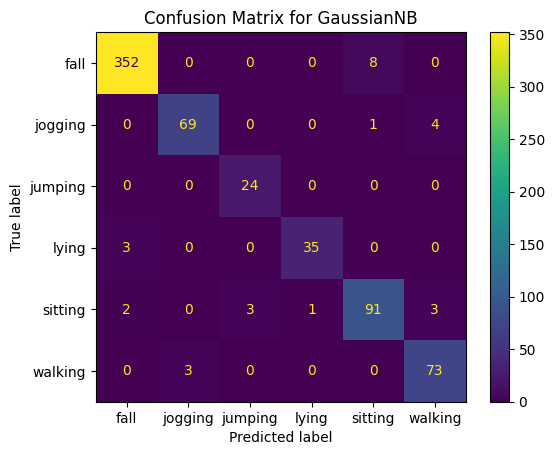

Model: LogisticRegression
Classification Report:
              precision    recall  f1-score   support

        fall       0.99      0.99      0.99       360
     jogging       0.99      0.96      0.97        74
     jumping       0.96      1.00      0.98        24
       lying       0.97      0.95      0.96        38
     sitting       0.98      0.97      0.97       100
     walking       0.94      0.99      0.96        76

    accuracy                           0.98       672
   macro avg       0.97      0.98      0.97       672
weighted avg       0.98      0.98      0.98       672

Confusion Matrix:
Accuracy: 0.9821



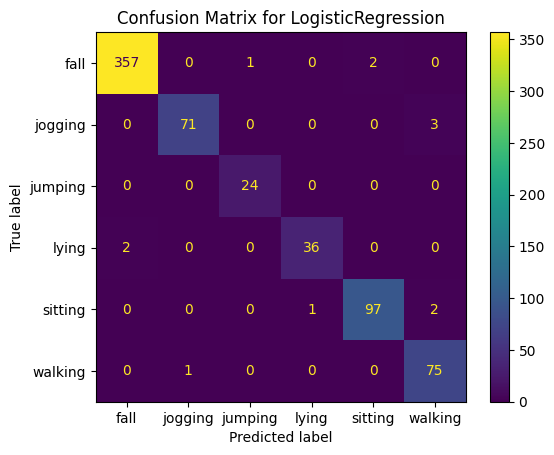

In [72]:


def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Model: {model.__class__.__name__}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='viridis')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

# Evaluate all models
evaluate_model(svm, X_test, y_test)
evaluate_model(rf, X_test, y_test)
evaluate_model(knn, X_test, y_test)
evaluate_model(dt, X_test, y_test)
evaluate_model(nb, X_test, y_test)
evaluate_model(lr, X_test, y_test)

      <!-- if activity_name == 'Walking':
                activity = 1
            elif activity_name == 'Jogging':
                activity = 2
            elif activity_name == 'GoDownstairs':
                activity = 5
            elif activity_name == 'GoUpstairs':
                activity = 6
            elif activity_name == 'LyingDown' and name_parts[5] == 'OnABed':
                activity = 7
            elif activity_name == 'Sitting' and name_parts[5] == 'GettingUpOnAChair':
                activity = 8
            
            
            
            elif activity_name == 'backwardFall':
                activity = 13
            elif activity_name == 'forwardFall':
                activity = 14
            elif activity_name == 'lateralFall':
                activity = 15
             -->

In [73]:
import os
import re

def uma_search_csv_files(directory, activities_of_interest=None):
    csv_files = []
    for current_folder, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                if activities_of_interest is not None:
                    for activity in activities_of_interest:
                        # Use regex to match exact activity number
                        pattern = rf"{activity}(?=Trial|_|\.csv)"
                        if re.search(pattern, file):
                            full_path = os.path.join(current_folder, file)
                            csv_files.append(full_path)
                            break
                else:
                    full_path = os.path.join(current_folder, file)
                    csv_files.append(full_path)
    return csv_files

In [75]:
# walking_uma_files = uma_search_csv_files(directory='output_uma', activities_of_interest=['Activity1'])

# # walkings_df = pd.concat([pd.read_csv(file) for file in walking_uma_files], ignore_index=True)
# walkings_df = pd.read_csv(walking_uma_files[0])
# walkings_df

In [ ]:
# walkings_df.rename(columns={
#     'Accelerometer: x-axis (g)': 'acc_x',
#     'Accelerometer: y-axis (g)': 'acc_y',
#     'Accelerometer: z-axis (g)': 'acc_z',
#     'Gyroscope: x-axis (rad/s)': 'gyro_x',
#     'Gyroscope: y-axis (rad/s)': 'gyro_y',
#     'Gyroscope: z-axis (rad/s)': 'gyro_z'
# }, inplace=True)


In [ ]:
# walkings_df

,TimeStamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,Subject,Activity,Trial,Tag
0,0.114,0.933594,0.130127,0.348633,0.016090,0.002318,-0.009681,15,1,1,0
1,0.136,0.933594,0.130127,0.348633,0.016090,0.002318,-0.009681,15,1,1,0
2,0.163,0.933594,0.130127,0.348633,0.016090,0.002318,-0.009681,15,1,1,0
3,0.208,1.002930,0.127930,0.353027,-0.038588,-0.010636,0.008318,15,1,1,0
4,0.256,1.009521,0.140381,0.353027,-0.022907,0.040906,-0.041452,15,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
294,14.746,0.923096,0.134033,0.386230,0.038452,-0.067632,-0.275435,15,1,1,0
295,14.798,0.934326,0.143799,0.393311,0.019635,-0.141263,-0.419015,15,1,1,0
296,14.846,0.937012,0.097656,0.400391,0.057541,-0.122446,-0.449695,15,1,1,0
297,14.897,1.005127,0.104980,0.398193,0.029589,-0.124627,-0.503418,15,1,1,0


In [ ]:
# walkings_df.drop(columns=['TimeStamp','Subject','Trial','Tag','Activity'])

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
0,0.933594,0.130127,0.348633,0.016090,0.002318,-0.009681
1,0.933594,0.130127,0.348633,0.016090,0.002318,-0.009681
2,0.933594,0.130127,0.348633,0.016090,0.002318,-0.009681
3,1.002930,0.127930,0.353027,-0.038588,-0.010636,0.008318
4,1.009521,0.140381,0.353027,-0.022907,0.040906,-0.041452
...,...,...,...,...,...,...
294,0.923096,0.134033,0.386230,0.038452,-0.067632,-0.275435
295,0.934326,0.143799,0.393311,0.019635,-0.141263,-0.419015
296,0.937012,0.097656,0.400391,0.057541,-0.122446,-0.449695
297,1.005127,0.104980,0.398193,0.029589,-0.124627,-0.503418


In [76]:
uma_files = uma_search_csv_files(directory=uma_dataset_folder, activities_of_interest=['Activity1','Activity2','Activity13', 'Activity14', 'Activity15'])

combined_df = pd.concat([pd.read_csv(file) for file in uma_files], ignore_index=True)

combined_df.rename(columns={
    'Accelerometer: x-axis (g)': 'acc_x',
    'Accelerometer: y-axis (g)': 'acc_y',
    'Accelerometer: z-axis (g)': 'acc_z',
    'Gyroscope: x-axis (rad/s)': 'gyro_x',
    'Gyroscope: y-axis (rad/s)': 'gyro_y',
    'Gyroscope: z-axis (rad/s)': 'gyro_z'
}, inplace=True)

# Display the shape of the combined dataframe
combined_df[700:710]


,TimeStamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,Subject,Activity,Trial,Tag
700,7.338,0.133057,0.416016,0.917480,-0.086039,-0.017181,-0.044724,15,14,3,0
701,7.344,0.14209,0.410400,0.921387,-0.02918,0.011317,-0.022907,15,14,3,0
702,7.349,0.14209,0.410400,0.921387,-0.02918,0.011317,-0.022907,15,14,3,0
703,7.384,0.137695,0.414551,0.915039,-0.029589,0.016362,-0.048133,15,14,3,0
704,7.433,0.132812,0.406738,0.918213,-0.024135,-0.015544,-0.047178,15,14,3,0
705,7.579,0.140869,0.412842,0.916260,-0.019226,-0.006136,-0.047587,15,14,3,0
706,7.582,0.140869,0.412842,0.916260,-0.019226,-0.006136,-0.047587,15,14,3,0
707,7.628,0.144775,0.407715,0.921875,-0.072131,-0.009817,-0.046497,15,14,3,0
708,7.631,0.140381,0.468262,0.917480,-0.076358,-0.013908,-0.046224,15,14,3,0
709,7.774,0.138184,0.465820,0.918457,-0.077449,-0.004227,-0.041452,15,14,3,0


In [77]:
grouped_data = []

# Sort by Subject, Activity, Trial, and TimeStamp to ensure proper ordering
combined_df_sorted = combined_df.sort_values(['Subject', 'Activity', 'Trial', 'TimeStamp']).reset_index(drop=True)

current_group = []
current_subject = None
current_activity = None
current_trial = None
group_id = 0

for idx, row in combined_df_sorted.iterrows():
    # Check if we're starting a new session (different subject/activity/trial)
    if (current_subject != row['Subject'] or 
        current_activity != row['Activity'] or 
        current_trial != row['Trial']):
        
        # Save the previous group if it exists
        if current_group:
            group_df = pd.DataFrame(current_group)

            if INCLUDE_GYROSCOPE:
                sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
            else:
                sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]

            timestamps = group_df['TimeStamp']
            
            group_row = {
                'subject': current_subject,
                'activity': f"D{current_activity}",
                'trial': current_trial,
                'group_id': group_id,
                'data': sensor_data,
                'timestamps': timestamps,
                'start_time': timestamps.iloc[0],
                'end_time': timestamps.iloc[-1],
                'duration': len(timestamps),
                'sampling_rate': len(timestamps) / (timestamps.iloc[-1] - timestamps.iloc[0]) if len(timestamps) > 1 else 0
            }
            grouped_data.append(group_row)
            group_id += 1
        
        # Start new group
        current_group = [row.to_dict()]
        current_subject = row['Subject']
        current_activity = row['Activity']
        current_trial = row['Trial']
    else:
        # Check if timestamp has reset/jumped backwards (indicating new data segment)
        if current_group:
            last_timestamp = current_group[-1]['TimeStamp']
            current_timestamp = row['TimeStamp']
            
            # If current timestamp is less than or equal to previous (reset occurred)
            if current_timestamp <= last_timestamp:
                # Save the current group
                group_df = pd.DataFrame(current_group)
                if INCLUDE_GYROSCOPE:
                    sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
                else:   
                    sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]
                timestamps = group_df['TimeStamp']
                
                group_row = {
                    'subject': current_subject,
                    'activity': f"D{current_activity}",
                    'trial': current_trial,
                    'group_id': group_id,
                    'data': sensor_data,
                    'timestamps': timestamps,
                    'start_time': timestamps.iloc[0],
                    'end_time': timestamps.iloc[-1],
                    'duration': len(timestamps),
                    'sampling_rate': len(timestamps) / (timestamps.iloc[-1] - timestamps.iloc[0]) if len(timestamps) > 1 else 0
                }
                grouped_data.append(group_row)
                group_id += 1
                
                # Start new group with current row
                current_group = [row.to_dict()]
            else:
                # Continue adding to current group
                current_group.append(row.to_dict())
        else:
            current_group.append(row.to_dict())

# Don't forget the last group
if current_group:
    group_df = pd.DataFrame(current_group)
    if INCLUDE_GYROSCOPE:
        sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
    else:
        sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]
    timestamps = group_df['TimeStamp']
    
    group_row = {
        'subject': current_subject,
        'activity': f"D{current_activity}",
        'trial': current_trial,
        'group_id': group_id,
        'data': sensor_data,
        'timestamps': timestamps,
        'start_time': timestamps.iloc[0],
        'end_time': timestamps.iloc[-1],
        'duration': len(timestamps),
        'sampling_rate': len(timestamps) / (timestamps.iloc[-1] - timestamps.iloc[0]) if len(timestamps) > 1 else 0
    }
    grouped_data.append(group_row)

# Convert to DataFrame
uma_dataset = pd.DataFrame(grouped_data)
print(f"Created {len(uma_dataset)} data segments based on timestamp breaks")
print(f"Segments per activity:")
activity_counts = uma_dataset['activity'].value_counts()
print(activity_counts)

# Show additional timestamp info
print(f"\nTimestamp information:")
print(f"Average segment duration: {uma_dataset['duration'].mean():.1f} samples")
print(f"Average sampling rate: {uma_dataset['sampling_rate'].mean():.1f} Hz")

uma_dataset

Created 281 data segments based on timestamp breaks
Segments per activity:
activity
D13    68
D14    67
D15    63
D1     55
D2     28
Name: count, dtype: int64

Timestamp information:
Average segment duration: 294.3 samples
Average sampling rate: 19.9 Hz


,subject,activity,trial,group_id,data,timestamps,start_time,end_time,duration,sampling_rate
0,1,D1,1,0,acc_x acc_y acc_z 0 -0.74023...,0 0.782 1 0.831 2 0.879 3 ...,0.782,14.981,285,20.071836
1,1,D1,2,1,acc_x acc_y acc_z 0 -0.76416...,0 0.350 1 0.361 2 0.369 3 ...,0.350,15.002,301,20.543271
2,1,D1,3,2,acc_x acc_y acc_z 0 -0.75732...,0 0.154 1 0.183 2 0.201 3 ...,0.154,14.958,300,20.264793
3,2,D1,1,3,acc_x acc_y acc_z 0 -0.95336...,0 0.115 1 0.145 2 0.163 3 ...,0.115,14.965,299,20.134680
4,2,D1,2,4,acc_x acc_y acc_z 0 -0.96289...,0 0.164 1 0.187 2 0.207 3 ...,0.164,14.951,299,20.220464
...,...,...,...,...,...,...,...,...,...,...
276,19,D15,2,276,acc_x acc_y acc_z 0 -1.02294...,0 0.269 1 0.331 2 0.337 3 ...,0.269,14.979,281,19.102651
277,19,D15,3,277,acc_x acc_y acc_z 0 -1.37255...,0 0.218 1 0.282 2 0.326 3 ...,0.218,14.970,293,19.861714
278,19,D15,4,278,acc_x acc_y acc_z 0 -0.92089...,0 0.222 1 0.306 2 0.396 3 ...,0.222,14.950,296,20.097773
279,19,D15,5,279,acc_x acc_y acc_z 0 -0.90795...,0 0.211 1 0.274 2 0.351 3 ...,0.211,15.016,299,20.195880


In [78]:
uma_dataset['data'][0]

,acc_x,acc_y,acc_z
0,-0.740234,0.571289,0.249512
1,-0.842285,0.598145,0.297119
2,-0.833252,0.425781,0.332031
3,-0.721191,0.518311,0.116455
4,-0.741699,0.651611,0.380127
...,...,...,...
280,-0.878662,0.503418,0.118896
281,-0.760742,0.463623,0.170898
282,-0.702393,0.350342,0.258301
283,-0.600098,0.412842,0.168457


In [79]:
# grouped_data = []

# for (subject, activity, trial), group in combined_df.groupby(['Subject', 'Activity', 'Trial']):
#     # Extract only sensor data columns
#     sensor_data = group[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
    
#     # Create a row with metadata and sensor data
#     row = {
#         'subject': subject,
#         'activity': f"D{activity}", 
#         'trial': trial,
#         'data': sensor_data
#     }
#     grouped_data.append(row)

# # Convert to DataFrame
# uma_dataset = pd.DataFrame(grouped_data)
# uma_dataset

In [80]:
import itertools
import numpy as np
import pandas as pd  # Don't forget this if not imported already

# def extract_features(data, with_magnitude):
#     """
#     Extracts various features from the time and frequency domains from a given sample of activity.
#     Also constructs features by combining the raw data.

#     :param data: the data from the activity (Pandas DataFrame)
#     :param with_magnitude: whether to calculate the magnitude of the 3-axis sensor data
#     :return: DataFrame with all the features extracted from the activity
#     """

#     # Ensure all data is numeric: convert strings to NaN, then fill with 0
#     data = data.apply(pd.to_numeric, errors='coerce').fillna(0)

#     # Calculate magnitude features
#     if with_magnitude:
#         for i in range(0, data.shape[1], 3):
#             slice_ = data.iloc[:, i:i+3]
#             magnitude = np.linalg.norm(slice_, axis=1)
#             name = 'mag_' + data.columns[i][0:len(data.columns[i])-2]
#             data[name] = magnitude

#     # Feature names
#     names = ['mean', 'var', 'std', 'median', 'max', 'min', 'ptp', 'centile25', 'centile75']
#     columns = list('_'.join(n) for n in itertools.product(names, data.columns.tolist()))

#     # Time domain features
#     features = np.mean(data, axis=1)
#     features = np.hstack((features, np.var(data, axis=1)))
#     features = np.hstack((features, np.std(data, axis=1)))
#     features = np.hstack((features, np.median(data, axis=1)))
#     features = np.hstack((features, np.max(data, axis=1)))
#     features = np.hstack((features, np.min(data, axis=1)))
#     features = np.hstack((features, np.ptp(data, axis=1)))
#     features = np.hstack((features, np.percentile(data, 25, axis=1)))
#     features = np.hstack((features, np.percentile(data, 75, axis=1)))

#     return pd.DataFrame([features], columns=columns)

def extract_features(data, with_magnitude):
    """
    Extracts various features from the time and frequency domains from a given sample of activity. Also constructs
    features by combining the raw data.

    :param data: the data from the activity
    :param with_magnitude: calculate the magnitude of the sensors
    :return: list with all the features extracted from the activity
    """
    
    # Make a copy to avoid modifying original data
    data = data.copy()
    
    # Clean and ensure all data is numeric
    for col in data.columns:
        # Convert to string first, then replace any concatenated values
        data[col] = data[col].astype(str)
        # If values are concatenated, this won't work well, so let's handle it
        data[col] = pd.to_numeric(data[col], errors='coerce')
    
    # Fill any NaN values with 0
    data = data.fillna(0)
    
    # Check if we still have any non-numeric data
    if not data.select_dtypes(include=[np.number]).shape[1] == data.shape[1]:
        print("Warning: Non-numeric data detected, attempting to clean...")
        # Additional cleaning if needed
        for col in data.columns:
            if data[col].dtype == 'object':
                print(f"Column {col} contains non-numeric data")
                data[col] = 0  # Set problematic columns to 0
    
    # Calculates the acceleration and rotation magnitudes
    if with_magnitude:
        for i in range(0, data.shape[1], 3):
            if i + 2 < data.shape[1]:  # Ensure we have 3 columns
                # Select the 3-axis slice
                slice_ = data.iloc[:, i:i+3]
                
                # Compute magnitude
                magnitude = np.linalg.norm(slice_, axis=1)
                
                # Generate magnitude column name
                name = 'mag_' + data.columns[i][0:len(data.columns[i])-2]
                
                # Assign magnitude column
                data[name] = magnitude

    # Creates features vector name
    names = ['mean', 'var', 'std', 'median', 'max', 'min', 'ptp', 'centile25', 'centile75']
    columns = list('_'.join(n) for n in itertools.product(names, data.columns.tolist()))

    # Time domain features
    features = np.mean(data, axis=0)
    features = np.hstack((features, np.var(data, axis=0)))
    features = np.hstack((features, np.std(data, axis=0)))
    features = np.hstack((features, np.median(data, axis=0)))
    features = np.hstack((features, np.max(data, axis=0)))
    features = np.hstack((features, np.min(data, axis=0)))
    features = np.hstack((features, np.ptp(np.asarray(data), axis=0)))
    features = np.hstack((features, np.percentile(data, 25, axis=0)))
    features = np.hstack((features, np.percentile(data, 75, axis=0)))

    # Creates a DataFrame
    features = pd.DataFrame([features], columns=columns)
    return features

# Extract features from uma_dataset
print("Processing UMA dataset...")
feature_list = []
labels = []
subjects = []
activity_codes = []

for i in uma_dataset.index:
    # Get data from each row
    data = uma_dataset['data'][i]
    
    # Extract features
    features_uma = extract_features(data, True)
    
    # Store results
    feature_list.append(features_uma)
    subjects.append(uma_dataset['subject'][i])
    activity_codes.append(uma_dataset['activity'][i])

# Combine into final dataset
uma_prepared_dataset = pd.concat(feature_list, ignore_index=True)
uma_prepared_dataset['subject'] = subjects
uma_prepared_dataset['activity_code'] = activity_codes

print(f"UMA dataset shape: {uma_prepared_dataset.shape}")
print("\nActivity code distribution:")
print(uma_prepared_dataset['activity_code'].value_counts())

uma_prepared_dataset

Processing UMA dataset...
UMA dataset shape: (281, 38)

Activity code distribution:
activity_code
D13    68
D14    67
D15    63
D1     55
D2     28
Name: count, dtype: int64


,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,subject,activity_code
0,-0.748402,0.572373,0.265424,0.989671,0.010993,0.009095,0.012568,0.011373,0.104850,0.095367,...,-0.812744,0.504150,0.204346,0.918750,-0.674072,0.633789,0.338379,1.046824,1,D1
1,-0.648921,0.610286,0.361364,0.999880,0.036785,0.015908,0.038167,0.015232,0.191793,0.126126,...,-0.765381,0.549805,0.231689,0.928399,-0.610352,0.674561,0.394531,1.055870,1,D1
2,-0.642502,0.666831,0.311903,0.985959,0.010756,0.009004,0.008315,0.010715,0.103709,0.094890,...,-0.731873,0.600159,0.235718,0.917690,-0.567505,0.749023,0.382202,1.034498,1,D1
3,-1.043552,-0.281974,0.108950,1.114262,0.077249,0.024974,0.031381,0.072405,0.277937,0.158032,...,-1.207764,-0.375854,0.008301,0.953660,-0.876465,-0.184448,0.216675,1.261053,2,D1
4,-0.877046,-0.428425,0.229331,1.070247,0.087546,0.056010,0.087403,0.090880,0.295881,0.236664,...,-1.005859,-0.545898,0.068726,0.920448,-0.725220,-0.288696,0.365967,1.128142,2,D1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,-0.198070,0.358674,0.618709,1.052136,0.152059,0.229037,0.209130,0.033916,0.389947,0.478578,...,-0.272461,-0.112061,0.579102,0.971959,-0.060791,0.700684,0.864258,1.090969,19,D15
277,-0.144246,0.619491,-0.081711,1.126797,0.184675,1.139300,0.496442,0.961999,0.429738,1.067380,...,-0.020020,0.783691,-0.081299,0.935022,-0.008301,0.937256,0.035400,1.004671,19,D15
278,-0.619123,-0.596731,0.389268,1.068791,0.053604,0.128418,0.136904,0.067544,0.231526,0.358355,...,-0.708740,-0.774841,0.178711,0.986254,-0.533203,-0.464844,0.564209,1.084290,19,D15
279,-0.144801,0.470989,-0.601326,0.959936,0.084430,0.114638,0.153182,0.035164,0.290569,0.338582,...,-0.089111,0.479614,-0.769409,0.905493,-0.045898,0.631104,-0.670776,0.959350,19,D15


In [81]:
UMA_ACTIVITY_MAPPING = {
    'D1': 'walking',
    'D2': 'jogging',
    'D13': 'fall',
    'D14': 'fall',
    'D15': 'fall'
}

activity_codes = uma_prepared_dataset['activity_code'] 
y_labels = activity_codes.map(UMA_ACTIVITY_MAPPING)


X_uma = uma_prepared_dataset.drop(columns=['activity_code', 'subject'])
X_uma.shape

(281, 36)

In [82]:
predicted_uma_fall = svm.predict(X_uma)
confusion_matrix(y_labels, predicted_uma_fall)

array([[193,   0,   1,   4,   0],
       [ 13,  15,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [ 14,   0,  19,  22,   0]])

In [83]:
predicted_uma_fall_dt = dt.predict(X_uma)
confusion_matrix(y_labels, predicted_uma_fall)

array([[193,   0,   1,   4,   0],
       [ 13,  15,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [ 14,   0,  19,  22,   0]])

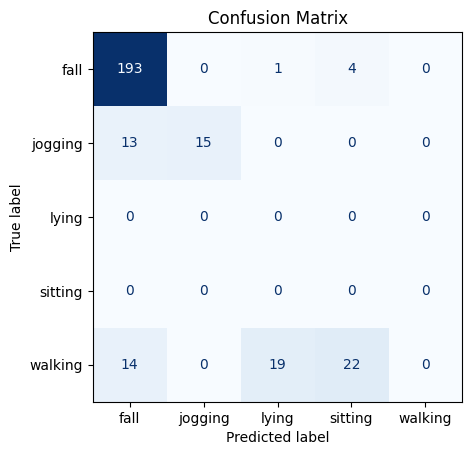

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_labels, predicted_uma_fall)

# Ensure the labels match the unique classes in the confusion matrix
unique_classes = np.unique(np.concatenate((y_labels, predicted_uma_fall)))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
disp.plot(cmap='Blues', colorbar=False)
plt.title("Confusion Matrix")
plt.show()

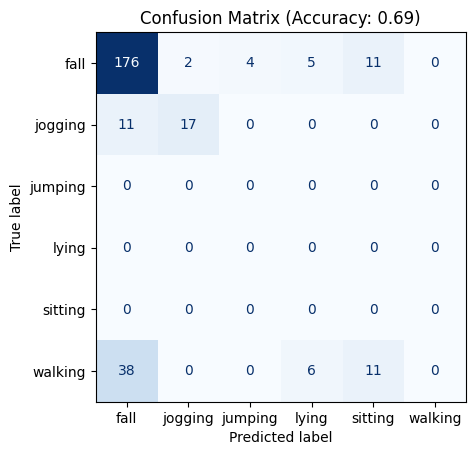

In [85]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

# Generate confusion matrix
cm = confusion_matrix(y_labels, predicted_uma_fall_dt)

# Calculate accuracy
accuracy = accuracy_score(y_labels, predicted_uma_fall_dt)

# Ensure the labels match the unique classes in the confusion matrix
unique_classes = np.unique(np.concatenate((y_labels, predicted_uma_fall_dt)))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
disp.plot(cmap='Blues', colorbar=False)
plt.title(f"Confusion Matrix (Accuracy: {accuracy:.2f})")
plt.show()

In [ ]:
y_labels_unq = np.unique(y_labels)
y_labels_unq

array(['fall', 'jogging', 'walking'], dtype=object)

In [ ]:
unique_labels = np.unique(predicted_uma_fall)
unique_labels

array(['fall', 'jogging', 'lying', 'sitting'], dtype=object)

In [ ]:
falls_uma = uma_search_csv_files(directory='output_uma', activities_of_interest=['Activity13', 'Activity14', 'Activity15'])

features_uma_list = []

for file in falls_uma:
    data = pd.read_csv(file).drop(columns=['Subject', 'Activity', 'Trial', "Tag", 'TimeStamp'])
    data.rename(columns={
        'Accelerometer: x-axis (g)': 'acc_x',
        'Accelerometer: y-axis (g)': 'acc_y',
        'Accelerometer: z-axis (g)': 'acc_z',
        'Gyroscope: x-axis (rad/s)': 'gyro_x',
        'Gyroscope: y-axis (rad/s)': 'gyro_y',
        'Gyroscope: z-axis (rad/s)': 'gyro_z'
    }, inplace=True)
    extracted_features = extract_features(data, True)
    features_uma_list.append(extracted_features)

# Combine all features into a single DataFrame
features_uma = pd.concat(features_uma_list, ignore_index=True)
features_uma

,mean_acc_x,mean_acc_y,mean_acc_z,mean_gyro_x,mean_gyro_y,mean_gyro_z,mean_mag_acc,mean_mag_gyro,var_acc_x,var_acc_y,...,centile25_mag_acc,centile25_mag_gyro,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_gyro_x,centile75_gyro_y,centile75_gyro_z,centile75_mag_acc,centile75_mag_gyro
0,0.199561,0.278816,0.914422,-0.003465,0.041201,0.016260,1.081096,0.307907,0.354210,0.015995,...,1.017806,0.069014,0.053467,0.299072,0.982910,-0.032725,-0.003954,-0.039406,1.034869,0.095359
1,0.317461,0.309403,0.857798,0.010423,0.053652,0.041546,1.146408,0.443001,0.481379,0.069006,...,1.046540,0.063773,0.145508,0.400879,1.016357,-0.021203,0.014044,-0.009136,1.099375,0.211700
2,0.292954,0.402263,0.827035,-0.043668,0.062946,0.008862,1.084703,0.293095,0.148859,0.072647,...,1.034253,0.064253,0.147339,0.465820,0.931641,-0.026589,-0.005420,-0.038043,1.050783,0.096008
3,0.166684,0.225140,0.912362,-0.008689,0.043272,-0.002048,1.089106,0.367263,0.329009,0.017361,...,1.025717,0.067345,0.073547,0.232239,1.066650,-0.031736,-0.006306,-0.039952,1.093615,0.130013
4,0.244600,0.507819,0.741087,-0.071796,0.057570,-0.060570,1.108212,0.334363,0.237477,0.130736,...,1.033047,0.066496,0.263977,0.622559,0.836182,-0.027646,0.010636,-0.038827,1.065072,0.173174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,-0.274163,0.528284,0.326733,-0.080084,0.044243,0.149956,1.033482,1.514574,0.151797,0.301327,...,0.933964,0.456395,-0.111816,0.929382,0.727661,0.628728,0.284945,0.208144,1.061113,2.037272
194,-0.619123,-0.596731,0.389268,-0.057137,-0.026538,0.080696,1.068791,1.106914,0.053604,0.128418,...,0.986254,0.168425,-0.533203,-0.464844,0.564209,0.128445,0.177158,0.139354,1.084290,1.640686
195,-0.144246,0.619491,-0.081711,-0.014795,-0.023733,0.157029,1.126797,1.261673,0.184675,1.139300,...,0.935022,0.065479,-0.008301,0.937256,0.035400,-0.024271,0.015953,-0.004909,1.004671,2.276280
196,-0.198070,0.358674,0.618709,0.133224,0.050611,0.012112,1.052136,1.228421,0.152059,0.229037,...,0.971959,0.250869,-0.060791,0.700684,0.864258,0.396381,0.138263,0.248709,1.090969,1.354890
